In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# load SBML model and get parameter labels
modelfile = os.getcwd()+'/models/240226MC_FULL.sbml' # filled nan values with mean for now
r = te.loadSBMLModel(modelfile)
parameter_values = r.getGlobalParameterValues()

In [3]:
# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations = simulation_ready['init_concentrations']   
    metadata = simulation_ready['metadata']
    measurements = simulation_ready['measurements']

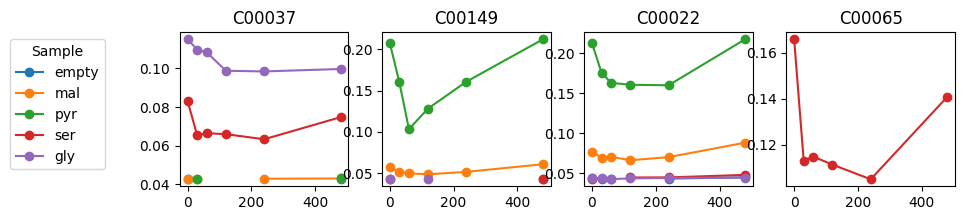

In [4]:
plt.figure(figsize=(10,2))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        # measurements[s][:,i] = measurements[s][:,i]*5
        plt.subplot(1,4,i+1)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title(m)
plt.legend(metadata['sample_labels'],bbox_to_anchor=(-4.65, 1), loc='upper left', title='Sample')

In [5]:
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
model_species = pd.read_csv(os.getcwd()+'/src/frenda_brenda/Files/SpeciesBaseMechanisms.csv')

In [6]:
v_to_c_map = {model_species.loc[model_species['Label'] == s, 'Relative'].values[0]:s for s in metabolites}

In [7]:
# get all the parameters that can vary during the fitting
kinetics_labels = [p for p in r.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki']])]
Gi_labels = [p for p in r.getGlobalParameterIds() if 'Gi' in p ]
metabolites_labels = [model_species.loc[model_species['Label'] == s, 'Relative'].values[0] for s in metabolites] #[s for s in r.getFloatingSpeciesIds() if 'EC' not in s]

parameter_labels = kinetics_labels + Gi_labels + metabolites_labels # + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*10 for i in kinetics_labels] + [1 for _ in Gi_labels] + [10 for i in metabolites_labels] + [1])
lower = np.array([r[i]/10 for i in kinetics_labels] + [0 for _ in Gi_labels] + [1/10 for i in metabolites_labels] + [1/1000])

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables = init_concentrations.copy()
for s in metadata['sample_labels']:
    variables[s] = {**variables[s] , **{'dilution_factor':1/metadata['dilution_factor'][s]}}
    variables[s] = {**variables[s] , **{p:1 for p in r.getGlobalParameterIds() if 'p_EC' in p}}

In [8]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi
myprob = SBMLGlobalFit_Multi(
    model = modelfile, 
    data = measurements, 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=metadata,
    variables=variables,
    scale=True)

prob = pg.problem(myprob)

In [12]:
myprob.fitness(upper)

In [70]:
udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})
mybfe = pg.bfe(udbfe)

# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
for i in range(5):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.01, variant=5, neighb_type=2, neighb_param=4)
    # a = pg.gaco(gen=10)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(prob, size = 0))

In [12]:
import ipyparallel as ipp
client = ipp.Client(profile='cheme-ecfers')
len(client[:])

720

In [ ]:
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS')

In [71]:
total_nodes = 40*18
init_std = 0.17

for p in pops:
    xs = (np.expand_dims(myprob._scale(lower*10),-1)@np.ones((1,total_nodes))*(1+np.random.normal(0, init_std,(len(lower),total_nodes)))).T + np.random.uniform(-0.08, 0.3, (total_nodes,len(lower)))    
    fs = udbfe._view.map_sync(myprob.fitness,xs)
    list(map(p.push_back, xs, fs))

In [18]:
import pickle

with open('logs.dat', 'rb') as file:
    logs = pickle.load(file)

with open('checkpoint.dat', 'rb') as file:
    pops = pickle.load(file)

In [72]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
logs = [[] for _ in range(5)]
for i in range(100):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))

    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('logs_c.dat', 'wb') as file:
        pickle.dump(logs, file)

    with open('checkpoint_c.dat', 'wb') as file:
        pickle.dump(pops, file)

    # if np.min([p.champion_f for p in pops]) < prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__()):
    #     break
    

02-03-2024, 13:30:51 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            720    4.76581e-07     0.00734811    7.26294e-07        5.59265
      2           1440    4.76581e-07     0.00828555    7.26266e-07        5.48166
      3           2160    4.76581e-07      0.0084597    7.26186e-07        5.38356
      4           2880    4.76581e-07     0.00811291    7.26182e-07        5.29892
      5           3600    4.76581e-07     0.00750483    7.26066e-07        5.23024
      6           4320    4.76581e-07     0.00685348     7.2544e-07         5.1808
      7           5040    4.76581e-07     0.00640188    7.24764e-07         5.1508
      8           5760    4.76581e-07     0.00613402    7.24744e-07         5.1343
      9           6480    4.76581e-07      0.0059011    7.24634e-07        5.12339

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            720    5.93905e-07    

KeyboardInterrupt: 

Text(0.5, 1.0, 'Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')

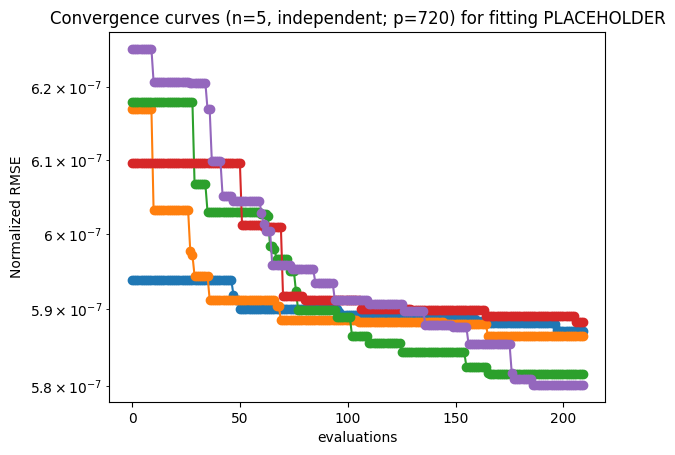

In [73]:
results = [np.concatenate(l,axis=0) for l in logs]
[plt.plot(res[:,2],'o-') for res in results]
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Normalized RMSE')
plt.xlabel('evaluations')
plt.title('Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')  

(array([ 20.,  67., 122., 159., 179., 165., 117.,  58.,  26.,   5.]),
 array([0.        , 0.04133539, 0.08267078, 0.12400617, 0.16534156,
        0.20667695, 0.24801234, 0.28934773, 0.33068312, 0.37201851,
        0.4133539 ]),
 <BarContainer object of 10 artists>)

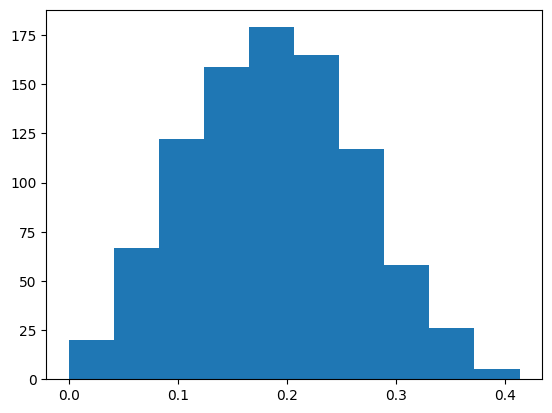

In [99]:
plt.hist(pops[0].get_x()[4,:])

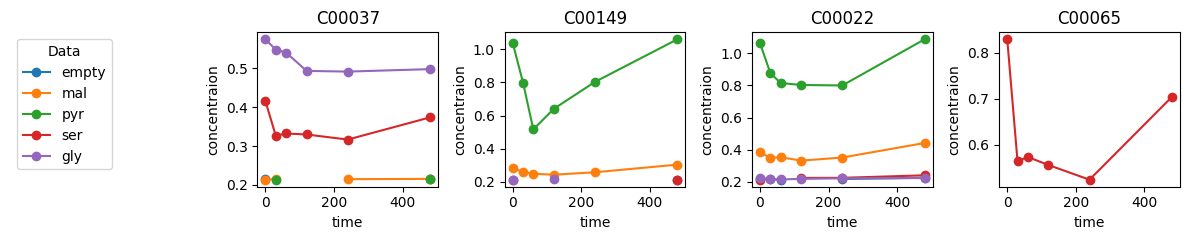

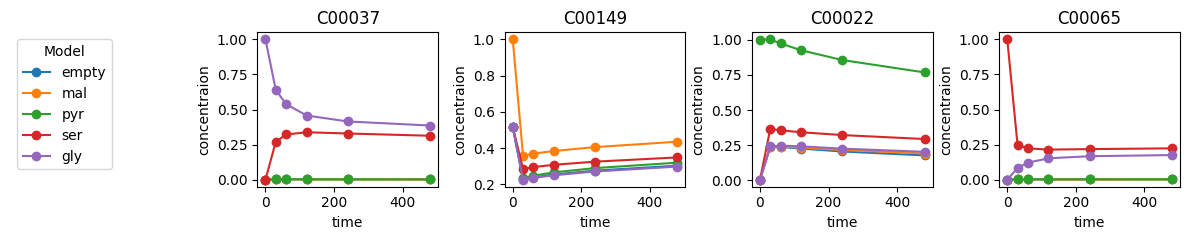

In [74]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentraion')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
plt.gca().axis('off')
plt.tight_layout()
    
all_results = {s:np.zeros(measurements[s].shape) for s in metadata['sample_labels']}
for k,c in enumerate([p.champion_x for p in pops]):
    res_dict = myprob._simulate(myprob._unscale(c))
    all_results = {s:all_results[s] + res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]/len(pops) for s in metadata['sample_labels']}

plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        plt.plot(metadata['timepoints'][s]/60, all_results[s][:,i],'-o')
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentraion')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()
    